In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

import mysql.connector

%matplotlib inline

## Race results

In [2]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

In [3]:
len(df_results.athlete.unique())

643055

## Races info

In [4]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

### Some processing on the datasets

In [26]:
# -----------
# -- RACES --
# -----------


# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# remove duplicates
df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# remove worldchampionship
df_races = df_races.loc[df_races.race != 'worldchampionship70.3']
df_races = df_races.loc[df_races.race != 'worldchampionship']


# add Country codes
with open("./../data/geo-data/races_geo_info.json", 'r') as f:
    races_geo_info = json.loads(f.read())
             
df_races['country_code'] = None
for race in df_races.race.values:
    country_code = races_geo_info[race]
    df_races.loc[df_races.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']

# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races['race'])]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# keep only results from before 2019
df_results = df_results.loc[df_results['year'] < 2019]

# discard pro athletes
df_results = df_results.loc[df_results.division.str.contains("PRO") == False]

# Add gender
df_results['gender'] = None
df_results.loc[df_results['division'].str.contains("M"), 'gender'] = "M"
df_results.loc[df_results['division'].str.contains("F"), 'gender'] = "F"

### what do we have left to work with?

In [27]:
print('-- Results dataset --')
print(f"  Number of single results: {len(df_results)}")
print(f"  Number of athletes: {len(df_results.athlete.unique())}")

print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Results dataset --
  Number of single results: 1592599
  Number of athletes: 575481
-- Races dataset --
  Number of active races: 157


## Race count per athlete

In [28]:
athletes_df = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)
athletes_df.sort_values(by="n_races", ascending=False).head(10)

,athlete,n_races
521008,Taiwan Triathlete,686
130992,David Smith,174
386475,Michael Smith,156
128290,David Jones,152
488537,Scott Smith,133
265922,John Wragg,132
68891,Brian Smith,126
381071,Michael Brown,120
32060,Andrew Smith,113
128731,David Lee,111


#### To prevent cold-start keep only people with > 4 races. Also remove people with > 100 races

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,bib,country,date,fulldata,score,swim_score,run_score,bike_score,gender,n_races
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,167,USA,2016-11-13,0,98.4,100.0,86.1,100.0,M,10
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,1779,JPN,2016-11-13,0,97.1,77.2,100.0,90.7,M,12
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,133,AUS,2016-11-13,0,99.9,100.0,100.0,99.7,M,24
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,1780,JPN,2016-11-13,0,100.0,100.0,100.0,100.0,M,15
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,1737,ESP,2016-11-13,0,99.6,100.0,98.3,99.0,M,9


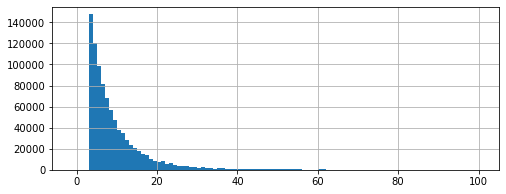

In [29]:
# we will use this filtered df from now on
df_results_filtered = df_results.merge(athletes_df, left_on="athlete", right_on="athlete", how="left")
df_results_filtered = df_results_filtered.loc[(df_results_filtered['n_races']>3) & (df_results_filtered['n_races']<=100)]

# also remove athletes in athlete_df
athletes_df = athletes_df.loc[(athletes_df['n_races']>3) & (athletes_df['n_races']<=100)]

df_results_filtered['n_races'].hist(bins=np.arange(-0.99, 100.99, 1), figsize=(8, 3))
df_results_filtered.head(5)

A majority of athletes have < 20 races

In [30]:
print('-- Results dataset --')
print(f"  Number of single results: {len(df_results_filtered)}")
print(f"  Number of athletes: {len(df_results_filtered.athlete.unique())}")

-- Results dataset --
  Number of single results: 909284
  Number of athletes: 126612


## Anonimize entrants

In [55]:
user_hash = {}

for i,user in enumerate(df_results_filtered.athlete.unique()):
    user_hash[user] = f'u{i}'

df_results_filtered.loc[:, 'athlete'] = df_results_filtered.athlete.map(lambda x: user_hash[x])

# MODEL 1: the more you do a race, the more you implicitely like it

#### Count of each race for each entrants

In [61]:
user_data = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

user_data.head()

,athlete,race,count
0,u0,brazil,1
1,u0,california70.3,1
2,u0,cozumel,2
3,u0,honu70.3,1
4,u0,loscabos,2


#### How many times the race has been done

In [62]:
race_popularity = (user_data
    .groupby(by = ['race'])['count']
    .sum()
    .reset_index()
    .rename(columns = {'count': 'total_count'})
)
race_popularity.head()

,race,total_count
0,Arizona70.3,3988
1,DunLaoghaire70.3,511
2,Florianopolis70.3,497
3,Haugesund70.3,1438
4,IMsubicbay,841


In [64]:
print(race_popularity['total_count'].describe())
# print(race_popularity['total_count'].quantile(np.arange(.5, 1, .01)))

count      153.00000
mean      5943.03268
std       6168.27001
min        126.00000
25%       1630.00000
50%       3399.00000
75%       8303.00000
max      30975.00000
Name: total_count, dtype: float64


#### Add demographics info for users (if we want to filter later)

In [63]:
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

user_data_with_race_count = user_data.merge(race_popularity, left_on = 'race', right_on = 'race', how = 'left')
user_data_with_race_count = user_data_with_race_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
user_data_with_race_count = user_data_with_race_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')
user_data_with_race_count.head(10)

,athlete,race,count,total_count,gender,country
0,u0,brazil,1,10406,M,USA
1,u0,california70.3,1,24896,M,USA
2,u0,cozumel,2,12894,M,USA
3,u0,honu70.3,1,13529,M,USA
4,u0,loscabos,2,2987,M,USA
5,u0,mardelplata,1,1359,M,USA
6,u0,xiamen70.3,2,1311,M,USA
7,u1,cairns,1,5841,M,JPN
8,u1,canada70.3,1,1710,M,JPN
9,u1,honu70.3,3,13529,M,JPN


## --## -- Implemeting the Nearest Neighbor Model

#### Reshaping the Data

For K-Nearest Neighbors, we want the data to be in an m x n array, where m is the number of artists and n is the number of users. To reshape the dataframe, we’ll pivot the dataframe to the wide format with artists as rows and users as columns. Then we’ll fill the missing observations with 0s since we’re going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [280]:
from scipy.sparse import csr_matrix, save_npz

wide_race_data = user_data_with_race_count.pivot(index = 'race', columns = 'athlete', values = 'count').fillna(0)
wide_race_data_sparse = csr_matrix(wide_race_data.values)

save_npz('./../data/matrices/ironman_sparse_race_matrix.npz', wide_race_data_sparse)

#### Fitting the Model

Time to implement the model. We’ll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [285]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_race_data_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

#### Making Recommendations

And we’re finally ready to make some recommendations!

In [286]:
query_index = 93#np.random.choice(wide_race_data.shape[0])
distances, indices = model_knn.kneighbors(wide_race_data.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {wide_race_data.index[query_index]}:\n')
    else:
        print(f'{i}: {wide_race_data.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}.')

Recommendations for monterrey70.3:

1: cancun70.3, with distance of 0.6506954930959081.
2: campeche70.3, with distance of 0.6885058762301839.
3: loscabos70.3, with distance of 0.7733380585562504.
4: cozumel, with distance of 0.7915281981742285.
5: loscabos, with distance of 0.822613959647401.
6: longhorn70.3, with distance of 0.9016755648716765.
7: miami70.3, with distance of 0.9115206155799767.
8: costarica70.3, with distance of 0.9137633099205483.
9: texas, with distance of 0.9281587961262776.


# MODEL 2: Binary racing. Either an entrants raced a race or not

Previously, we used the actual play counts as values in our artist vectors. Another approach would be convert each vector into a binary (1 or 0): either a user played the song or they did not. We can do this by applying the `sign` function in `numpy` to each column in the dataframe.

In [287]:
wide_race_data_zero_one = wide_race_data.apply(np.sign)
wide_race_data_zero_one_sparse = csr_matrix(wide_race_data_zero_one.values)

save_npz('./../data/matrices/ironman_sparse_race_matrix_binary.npz', wide_race_data_zero_one_sparse)

In [288]:
model_nn_binary = NearestNeighbors(metric='cosine', algorithm='brute')
model_nn_binary.fit(wide_race_data_zero_one_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

## Let’s make a quick comparison. Which recommendations look better?

In [289]:
distances, indices = model_nn_binary.kneighbors(wide_race_data_zero_one.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {wide_race_data_zero_one.index[query_index]}:\n')
    else:
        print(f'{i}: {wide_race_data_zero_one.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}.')

Recommendations for monterrey70.3:

1: cancun70.3, with distance of 0.5949644688540725.
2: campeche70.3, with distance of 0.6477200876756787.
3: loscabos70.3, with distance of 0.7559538413198565.
4: cozumel, with distance of 0.7783699298814024.
5: loscabos, with distance of 0.8219352857217571.
6: miami70.3, with distance of 0.8806283649860985.
7: costarica70.3, with distance of 0.8820301828306472.
8: longhorn70.3, with distance of 0.8940817121886645.
9: cartagena70.3, with distance of 0.8947414092533981.


The binary data representation recommendations look similar. The distances are actually lower.

Again, it’s not obvious which method is better. Since ultimately it’s the users’s future actions that indicate which recommender system is better, it’s a perfect candidate for A/B Testing. For now, I’ll stick with the non-binary data representation model.

## Implement pre-filtering

In [290]:
race_filter = df_races[['race', 'region', 'country_code']]
race_filter['is_70.3'] = race_filter['race'].str.contains('70.3')
race_filter = race_filter.set_index('race')
race_filter.head()

# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data.index)

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [292]:
df_to_filter_races.shape, race_filter.shape

((153, 3), (157, 3))

In [295]:
def get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False):
    if not filterBy:
        selection = df
    else:
        selection = df.loc[df[filterBy] == value]
    if returnIndices:
        return selection.index.map(lambda x: df.index.get_loc(x)).tolist()
    else:
        return selection.index.values

In [379]:
def get_prediction(similarTo, n=10, filterBy=False, value=False):
    if filterBy:
        selection_races = get_filtered_races(filterBy, value, df=df_to_filter_races)
        data = user_data_with_race_count.loc[user_data_with_race_count['race'].isin(selection_races)]
    else:
        data = user_data_with_race_count
    wide_data = data.pivot(index = 'race', columns = 'athlete', values = 'count')
    
    if similarTo not in wide_data.index:
        row_to_add = (user_data_with_race_count
                          .loc[user_data_with_race_count['race'] == similarTo]
                          .pivot(index='race', columns='athlete', values='count')
                     )
        # add row back if it was filtered out
        wide_data = pd.concat([wide_data, row_to_add], sort=False)
    wide_data.fillna(0, inplace=True)
    data_sparse = csr_matrix(wide_data.values)
        
    model_nn_binary = NearestNeighbors(metric='cosine', algorithm='brute')
    model_nn_binary.fit(data_sparse)
    query_index = np.where(wide_data.index == similarTo)[0][0]
    distances, indices = model_nn_binary.kneighbors(wide_data.iloc[query_index, :].values.reshape(1, -1), n_neighbors = n+1)
    distances = distances.flatten()
    indices = indices.flatten()
    return [(wide_data.index[indices[i]], distances[i]) for i in range(1, len(distances))]

In [342]:
get_prediction('Arizona70.3')

[('arizona', 0.7736384898213984),
 ('california70.3', 0.8404352348107171),
 ('stgeorge70.3', 0.8605120490629753),
 ('indianwellslaquinta70.3', 0.8769113761938605),
 ('santarosa70.3', 0.8917080098016437),
 ('boulder70.3', 0.9056888164995188),
 ('coeurdalene70.3', 0.9120193851189299),
 ('superfrog70.3', 0.9133741585841841),
 ('boulder', 0.9201549448746074),
 ('santacruz70.3', 0.9208661980619388)]

In [340]:
get_prediction('Arizona70.3', filterBy='is_70.3', value=False)

[('arizona', 0.7736384898213984),
 ('boulder', 0.9201549448746074),
 ('santarosa', 0.9376330769576309),
 ('texas', 0.9514385341974703),
 ('st.george', 0.9552544278237752),
 ('canada', 0.9604463044853202),
 ('louisville', 0.9645717610772782),
 ('florida', 0.9648819971399845),
 ('chattanooga', 0.9684485477956888),
 ('wisconsin', 0.970054183310547)]

## Faster prediction by pre-computing the matrix and fitting the model prior and filtering on the full results data

In [400]:
# precompute similarity matrix and do filtering as post-process
wide_race_data = user_data_with_race_count.pivot(index = 'race', columns = 'athlete', values = 'count').fillna(0)
wide_race_data_sparse = csr_matrix(wide_race_data.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_race_data_sparse)

# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data.index)

def get_prediction_fast(similarTo, n=10, filterBy=False, value=False):
    query_index = np.where(wide_race_data.index == similarTo)[0][0]
    total_n = wide_race_data.shape[0]
    distances, indices = model_knn.kneighbors(wide_race_data.iloc[query_index].values.reshape(1, -1), n_neighbors = total_n)
    distances = distances.flatten()
    indices = indices.flatten()
    
    if filterBy:
        selection_idx = get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False)
        n = n if n<len(selection_idx) else len(selection_idx)
        out_indices = []
        out_distances = []
        
        for indice,distance in zip(indices, distances):
            if ((wide_race_data.index[indice] in selection_idx) and (wide_race_data.index[indice] != similarTo)):
                out_indices.append(indice)
                out_distances.append(distance)
                if len(out_distances) >=n :
                    break
    
    return [(wide_race_data.index[indice], distance) for indice,distance in zip(out_indices, out_distances)]

In [402]:
get_prediction('monterrey70.3', filterBy='is_70.3', value=False)

[('cozumel', 0.7915281981742285),
 ('loscabos', 0.822613959647401),
 ('texas', 0.9281587961262776),
 ('boulder', 0.9524451534183321),
 ('arizona', 0.9682517042605463),
 ('florida', 0.9739153728375995),
 ('brazil', 0.97579722053371),
 ('barcelona', 0.979383712324602),
 ('santarosa', 0.9826026300880091),
 ('monttremblant', 0.9829504699790252)]

In [403]:
get_prediction_fast('monterrey70.3', filterBy='is_70.3', value=False)

[('cozumel', 0.7915281981742285),
 ('loscabos', 0.822613959647401),
 ('texas', 0.9281587961262776),
 ('boulder', 0.9524451534183321),
 ('arizona', 0.9682517042605463),
 ('florida', 0.9739153728375995),
 ('brazil', 0.97579722053371),
 ('barcelona', 0.979383712324602),
 ('santarosa', 0.9826026300880091),
 ('monttremblant', 0.9829504699790252)]